# **Traffic Sign Classification using Keras**
**Neural Networks - Final project <br>**
**Submitted by:** Team Rocket (Ajay, Akshita, Jonatas, Angelica, Kuldeep) <br>
**Instructor:** Mohammad Islam

## **Set up the dataset**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
np.random.seed(0)

# Open the pkl documents
with open('/content/drive/My Drive/NN/train.pkl', 'rb') as f:
  train_data = pickle.load(f)
with open('/content/drive/My Drive/NN/validate.pkl', 'rb') as f:
  val_data = pickle.load(f)
with open('/content/drive/My Drive/NN/test.pkl', 'rb') as f:
  test_data = pickle.load(f)
  
# Create datasets
X_train , y_train = train_data['features'], train_data['labels']
X_val , y_val = val_data['features'], val_data['labels']
X_test , y_test = test_data['features'], test_data['labels']

In [4]:
# Check the data shape
# trainset were created at 32px RGB format (hence, depth 3)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [5]:
# Assert for checking / debugging
assert(X_train.shape[0] == y_train.shape[0]), "train images not equal to label!"
assert(X_val.shape[0] == y_val.shape[0]), "val images not equal to label!"
assert(X_test.shape[0] == y_test.shape[0]), "test images not equal to label!"

assert(X_train.shape[1:] == (32,32,3)), "Dimension not 32 x 32 x 3!"
assert(X_val.shape[1:] == (32,32,3)), "Dimension not 32 x 32 x 3!"
assert(X_test.shape[1:] == (32,32,3)), "Dimension not 32 x 32 x 3!"

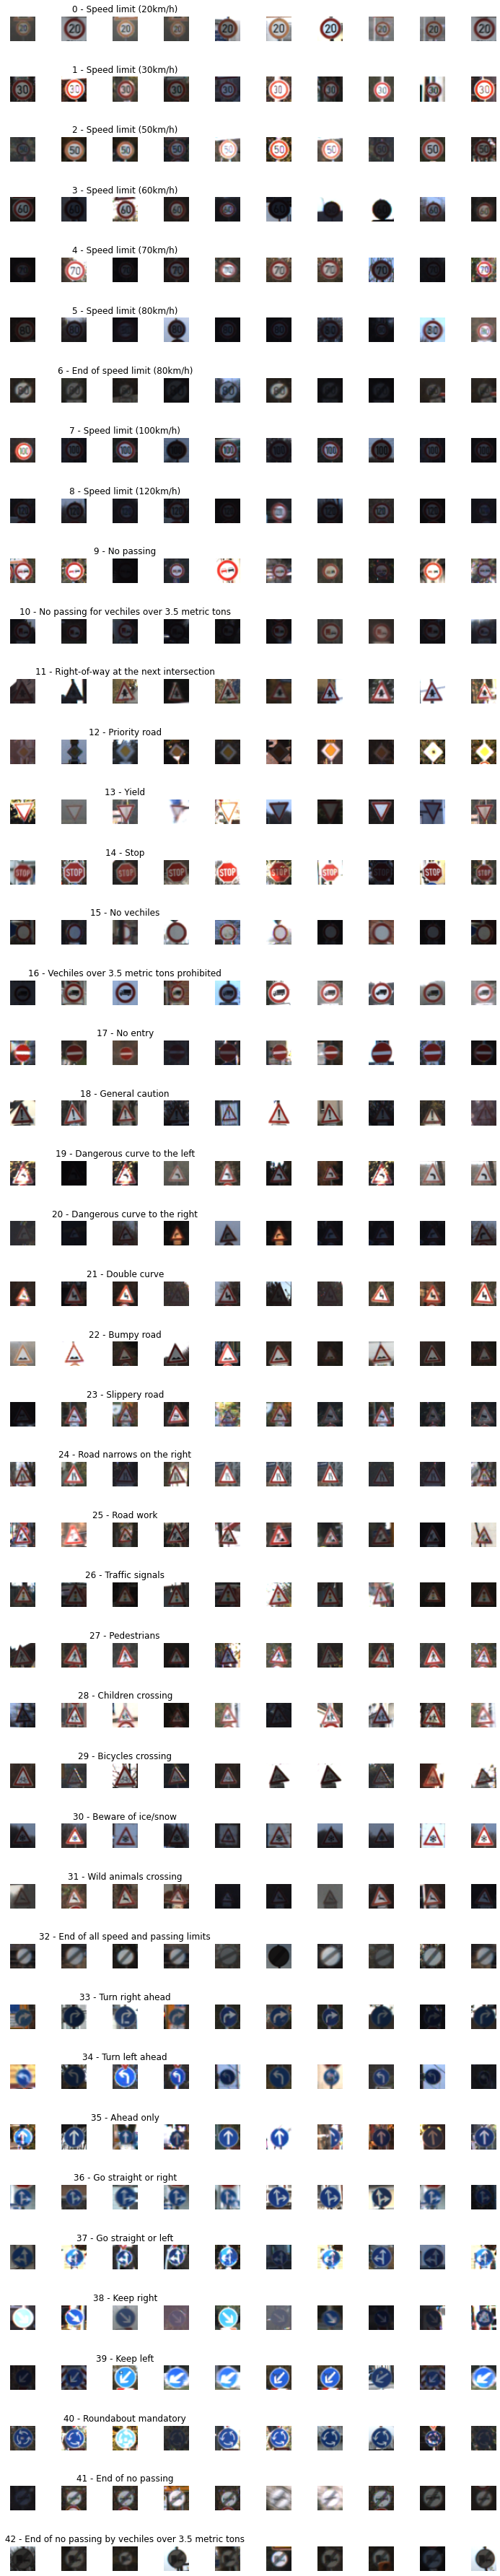

In [6]:
# Check and map the images against the label csv
data = pd.read_csv('/content/drive/My Drive/NN/label.csv')
samples=[]

cols = 10
classes = 43

fig, axs = plt.subplots(nrows=classes, ncols=cols, figsize=(10,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          samples.append(len(x_selected))

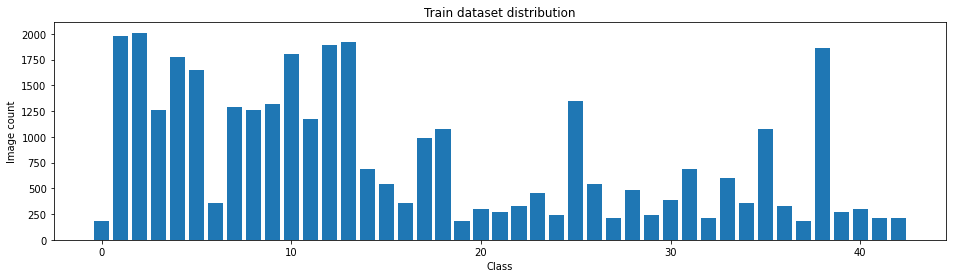

In [7]:
# Check the distribution of images to classes. ** Dataset is imbalanced **.
plt.figure(figsize=(16, 4))
plt.bar(range(0, classes), samples)
plt.title("Train dataset distribution")
plt.xlabel("Class")
plt.ylabel("Image count")
plt.show()

(32, 32, 3)
41


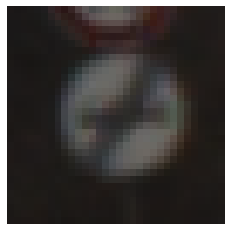

In [8]:
plt.imshow(X_train[1])
plt.axis("off")
print(X_train[1].shape)
print(y_train[1])

## **Data pre-processing / augmentation**

In [9]:
def preprocess(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # converting to grayscale
  img = cv2.equalizeHist(img) # histogram equalization for contrast adjustment 
  img = img/255 # image normalization to convert to values 0-1
  return img

# Pre-process the dataset
X_train = np.array(list(map(preprocess, X_train)))
X_val = np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess, X_test)))

(34799, 32, 32)


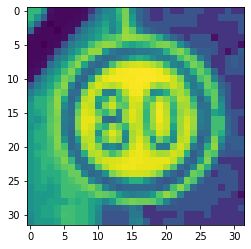

In [10]:
# Sample pre-processed image
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
print(X_train.shape)

In [11]:
# Adding depth required for CNN
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)


**Data Augmentation using Image Data Generator**

In [12]:
# Initiate image transformation/augmentation using keras.
from keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(width_shift_range=0.1,         # randomly transform pictures horizontally
                               height_shift_range=0.1,        # randomly transform pictures vertically
                               zoom_range=0.2,                # randomly zooming inside pictures
                               shear_range=0.1,               # randomly applying shearing transformations
                               rotation_range=10.)            # randomly rotate pictures

image_gen.fit(X_train)

(15, 32, 32, 1)


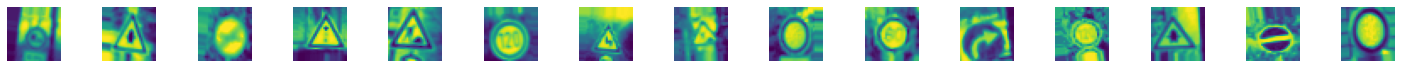

In [13]:
# Instantiate image_gen to trainset and their labels
batches = image_gen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

# Preview of the augmented images
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

## **CNN Model Training**

In [14]:
# Initially checking of dataset size and dim
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [15]:
# One-hot encode data labels using Keras to_categorical function
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [16]:
# Building and compiling the model
model = Sequential()

# Layer 1
model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2  
model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten, add dropout to reduce overfitting  
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

# Compile model  
model.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 60)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 30)        16230     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1080)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               540500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0

In [18]:
# Training the model using image_gen flow(data, labels) as inputs
history = model.fit(image_gen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch=len(X_train)//50,
                    epochs=15,
                    validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/15
695/695 [==============================] - 29s 19ms/step - loss: 2.6859 - accuracy: 0.2636 - val_loss: 0.8150 - val_accuracy: 0.7324
Epoch 2/15
695/695 [==============================] - 12s 17ms/step - loss: 1.0806 - accuracy: 0.6577 - val_loss: 0.4016 - val_accuracy: 0.8825
Epoch 3/15
695/695 [==============================] - 12s 18ms/step - loss: 0.7293 - accuracy: 0.7685 - val_loss: 0.2518 - val_accuracy: 0.9322
Epoch 4/15
695/695 [==============================] - 12s 18ms/step - loss: 0.5717 - accuracy: 0.8183 - val_loss: 0.2039 - val_accuracy: 0.9404
Epoch 5/15
695/695 [==============================] - 12s 17ms/step - loss: 0.4760 - accuracy: 0.8472 - val_loss: 0.2261 - val_accuracy: 0.9197
Epoch 6/15
695/695 [==============================] - 12s 17ms/step - loss: 0.4063 - accuracy: 0.8696 - val_loss: 0.1779 - val_accuracy: 0.9426
Epoch 7/15
695/695 [==============================] - 12s 17ms/step - loss: 0.3627 - accuracy: 0.8866 - val_loss: 0.1219 - val_accuracy:

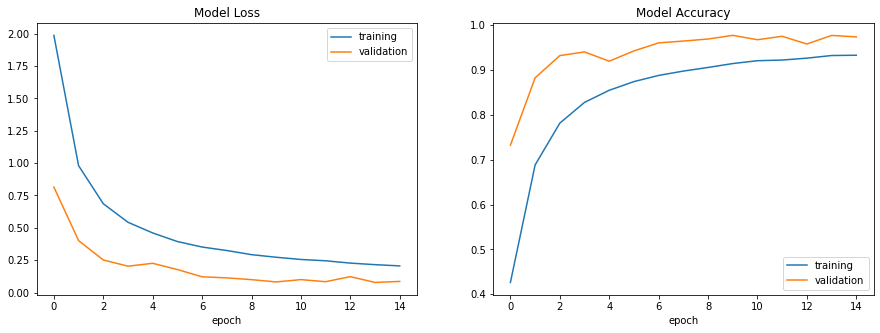

In [19]:
# Plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15,5))

# model loss plot
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['training', 'validation'])
ax1.title.set_text('Model Loss')
ax1.set_xlabel('epoch')

# model accuracy plot
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['training', 'validation'])
ax2.title.set_text('Model Accuracy')
ax2.set_xlabel('epoch')

plt.show()

In [20]:
# Model evaluation
score = model.evaluate(X_test, y_test , verbose = 0)
print("Accuracy score: ",score[1])

Accuracy score:  0.948060154914856


In [21]:
# Save model
model.save('/content/drive/My Drive/NN/model2.h5') 